## 1. Get the image data

In [1]:
import os
import pickle
import pandas as pd

data_file = '../Dataset/image_data'
with open(data_file, 'rb') as inFile:
    data = pickle.load(inFile)
data.head()

,id,name,image_url,price
0,bwCj2AcoOroZfCTxb6rCcg,A Better Burger,https://s3-media2.fl.yelpcdn.com/bphoto/3KS3Xs...,2
1,S9S9kFJSkmfpbjFForCWLQ,El Castillo,https://s3-media1.fl.yelpcdn.com/bphoto/NGC_GJ...,1
2,np8uV1xll22Yr-Q-B-ImkA,Rooster's Pub,,1
3,HGY1ojoLu07P_ky2LeRguQ,Redstone Restaurant,https://s3-media4.fl.yelpcdn.com/bphoto/BcdFv7...,1
4,J5XS3VmxnLKhNlpiwDJ-3A,Little Mexico,https://s3-media4.fl.yelpcdn.com/bphoto/P_X-58...,1


In [2]:
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

img_dir_old='../Dataset/Image'
files = os.listdir(img_dir_old)

img_dir='../Dataset/img'
train_path = os.path.join(img_dir, 'train')
test_path = os.path.join(img_dir, 'test')

for i in range(1, 5):
    if not os.path.exists(os.path.join(train_path, str(i))):
        os.makedirs(os.path.join(train_path, str(i)))
    if not os.path.exists(os.path.join(test_path, str(i))):
        os.makedirs(os.path.join(test_path, str(i)))
    

train_id_list = []
test_id_list = []
for file in files:
    fname = file[:-4]
    for i in range(len(data)):
        if fname == data.iloc[i,0]:
            if fname in train_set.id.values:
                train_id_list.append(fname)
                img = Image.open(os.path.join(img_dir_old, file))
                img.save(os.path.join(train_path+'/'+str(data.iloc[i,3]), file))
            elif fname in test_set.id.values:
                test_id_list.append(fname)
                img = Image.open(os.path.join(img_dir_old, file))
                img.save(os.path.join(test_path+'/'+str(data.iloc[i,3]), file))

In [3]:
print('Train_set size:',len(train_id_list))
print('Test_set size:',len(test_id_list))

Train_set size: 3891
Test_set size: 973


## 2. Train the image classifier

In [1]:
# Instantiate the VGG16 convolutional base
from keras.applications import VGG16

conv_base=VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
# weights: specify which weight checkpoint to initialize the model from
# include_top: include or not the densely-connected classifier on top of the network
# input_shape: the shape of image tensors that will feed to the network

conv_base.summary()

D:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
# Extract features using the pretrained convolutional base
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

img_dir='../Dataset/img'
train_path = os.path.join(img_dir, 'train')
test_path = os.path.join(img_dir, 'test')

datagen=ImageDataGenerator(rescale=1./255)
batch_size=100

def extract_features(directory, sample_count):
    features=np.zeros(shape=(sample_count, 4, 4, 512))
    labels=np.zeros(shape=(sample_count))
    generator=datagen.flow_from_directory(directory,target_size=(150,150),batch_size=batch_size,class_mode='sparse')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch=conv_base.predict(inputs_batch)
        if len(features_batch)!=batch_size:
            features[i*batch_size:i*batch_size+len(features_batch)]=features_batch
            labels[i*batch_size:i*batch_size+len(features_batch)]=labels_batch
        else:
            features[i*batch_size:(i+1)*batch_size]=features_batch
            labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size>=sample_count:
            break
    return features, labels

train_features, train_labels=extract_features(train_path, len(train_id_list))
test_features, test_labels=extract_features(test_path, len(test_id_list))

Found 3891 images belonging to 4 classes.
Found 973 images belonging to 4 classes.


In [6]:
# Flatten the features
train_features=np.reshape(train_features, (len(train_id_list),4*4*512))
test_features=np.reshape(test_features, (len(test_id_list),4*4*512))

In [7]:
# combine the image features with numerical data
data_file = '../Dataset/categories_data'
with open(data_file, 'rb') as inFile:
    num_data = pickle.load(inFile)
display(num_data.head())

train_rating = []
train_review = []
for idx in train_id_list:
    for i in range(len(num_data)):
        if idx==num_data.iloc[i,0]:
            train_rating.append(num_data.iloc[i,3])
            train_review.append(num_data.iloc[i,4])
test_rating = []
test_review = []
for idx in test_id_list:
    for i in range(len(num_data)):
        if idx==num_data.iloc[i,0]:
            test_rating.append(num_data.iloc[i,3])
            test_review.append(num_data.iloc[i,4])

train_num = pd.DataFrame()
train_num['rating']=train_rating
train_num['review']=train_review
test_num = pd.DataFrame()
test_num['rating']=test_rating
test_num['review']=test_review
X_train = np.hstack((train_num.values, train_features))
X_test = np.hstack((test_num.values, test_features))

,id,name,categories,rating,review_count,price
0,bwCj2AcoOroZfCTxb6rCcg,A Better Burger,"[{'alias': 'burgers', 'title': 'Burgers'}, {'a...",3.5,6,2
1,S9S9kFJSkmfpbjFForCWLQ,El Castillo,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.0,2,1
2,np8uV1xll22Yr-Q-B-ImkA,Rooster's Pub,"[{'alias': 'restaurants', 'title': 'Restaurant...",4.5,4,1
3,HGY1ojoLu07P_ky2LeRguQ,Redstone Restaurant,"[{'alias': 'newamerican', 'title': 'American (...",4.5,3,1
4,J5XS3VmxnLKhNlpiwDJ-3A,Little Mexico,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.0,5,1


In [8]:
# Train a MLP classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

nn = MLPClassifier(max_iter=10000)
nn.fit(X_train, train_labels)
nn_scores = cross_val_score(nn, X_train, train_labels, cv=5)
print('MLPClassifier Avg_Acc:', np.mean(nn_scores))
target_names = ['$', '$$', '$$$', '$$$$']
print(classification_report(test_labels, nn.predict(X_test), target_names=target_names))

MLPClassifier Avg_Acc: 0.5728588533657042
              precision    recall  f1-score   support

           $       0.45      0.47      0.46       353
          $$       0.64      0.66      0.65       585
         $$$       0.00      0.00      0.00        33
        $$$$       0.00      0.00      0.00         2

   micro avg       0.57      0.57      0.57       973
   macro avg       0.27      0.28      0.28       973
weighted avg       0.55      0.57      0.56       973



C:\Users\think\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
# Train a densely-connected neural network classifier
from keras import models
from keras import layers
from keras import optimizers

model=models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history=model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Train on 3112 samples, validate on 779 samples
Epoch 1/10
3112/3112 [==============================] - 4s 1ms/step - loss: 0.7028 - acc: 0.5566 - val_loss: 0.6263 - val_acc: 0.6252
Epoch 2/10
3112/3112 [==============================] - 4s 1ms/step - loss: 0.6319 - acc: 0.5819 - val_loss: 0.6165 - val_acc: 0.6226
Epoch 3/10
3112/3112 [==============================] - 4s 1ms/step - loss: 0.5923 - acc: 0.6089 - val_loss: 0.6121 - val_acc: 0.6252
Epoch 4/10
3112/3112 [==============================] - 4s 1ms/step - loss: 0.5835 - acc: 0.6256 - val_loss: 0.6195 - val_acc: 0.6226
Epoch 5/10
3112/3112 [==============================] - 4s 1ms/step - loss: 0.5503 - acc: 0.6452 - val_loss: 0.6046 - val_acc: 0.6367
Epoch 6/10
3112/3112 [==============================] - 4s 1ms/step - loss: 0.5263 - acc: 0.6616 - val_loss: 0.6021 - val_acc: 0.6431
Epoch 7/10
3112/3112 [==============================] - 4s 1ms/step - loss: 0.5170 - acc: 0.6648 - val_loss: 0.6024 - val_acc: 0.6470
Epoch 8/10
3112

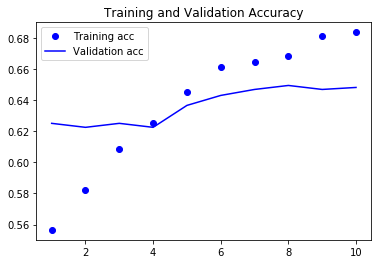

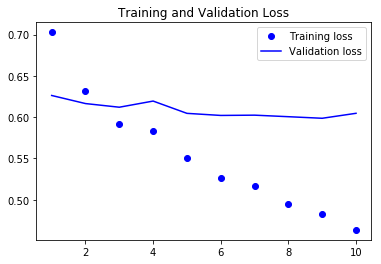

In [10]:
# Plot the results
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [11]:
result = model.evaluate(test_features, test_labels)
model.save('models/image_clf.h5')

973/973 [==============================] - 0s 208us/step


In [12]:
print(result)

[0.5656316899077131, 0.6341212744396735]
